## Assignment 2 Deep Learning - CNNs

_Magnus Caesar_

In [39]:
import numpy as np
import torch
import torch.utils.data as data
from load_func import load_mnist_func
import matplotlib.pyplot as plt
import time
np.random.seed(42)


### Exercise 1. Multi-layer fully connected neural network
Implement exactly the same network as for assignment 1.

1. Compare the performance
2. Compare speed
3. Learning curve plot

The first network from assignment 1 is a linear model. The input dimension is 784 (28x28 pixels) and the output dimension is 10. The second network is multilayered. The one I implemented had 2 hidden layers á 100 neurons each, which the same necessary input and output dimensions.

In [6]:
# Load the data
X_train, Y_train, X_test, Y_test = load_mnist_func("station")

Poopdogs
Reading MNIST: stationary


In [7]:
# Loading the data into pytorch's domain

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Create TensorDataset.
train_dataset = data.TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = data.TensorDataset(X_test_tensor, Y_test_tensor)

**Base network and forward**

Basic class for the network.

In [8]:
class SeqNetwork(torch.nn.Module):
    def __init__(self, num_hidden_layers, input_dim=784, output_dim=10, hidden_dim=100):
        super().__init__()
        self.layers = torch.nn.ModuleList([]) # Ska ha lista med lager / moduler

        # If no hidden layers
        if num_hidden_layers == 0: 
            self.layers.append(torch.nn.Linear(input_dim, output_dim, dtype=torch.float32))

        # If hidden layers layers
        # TODO
        # this might have some logic flaws
        else:
            # First layer
            self.layers.append(torch.nn.Linear(input_dim, hidden_dim))
            self.layers.append(torch.nn.ReLU())
            
            # Add extra layers
            for _ in range(num_hidden_layers):
                self.layers.append(torch.nn.Linear(hidden_dim, hidden_dim))
                self.layers.append(torch.nn.ReLU())
            
            self.layers.append(torch.nn.Linear(hidden_dim, output_dim))
        

    def forward(self, x):

        for l in self.layers:
            x = l(x)

        return x
        

**Computing loss**

This is the exact same "compute_loss" function used in lab 2.

In [38]:
def compute_loss(model, batch):
    # forward pass and loss function

    inp_data, labels = batch # Read current batch

    output = model(inp_data) # Get output from model
    loss = torch.nn.functional.cross_entropy(output, labels)
    acc = (output.argmax(dim=1) == labels.argmax(dim=1)).float().mean() # Check accuracy

    return loss, acc

**Optimizing**

The optimizer is SGD (as opposed to ADAM which comes later). PyTorch supports momentum, but that wasn't used in lab 1 and so won't be used here either.

In [11]:
model = SeqNetwork(0)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)

num_epochs = 50
batch_size = 100 # size used in lab1

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=64)



# Utilize mini-batch gradient descent
# After each batch: collect training cost and accuracy
# After each epoch (all batches: full data set)
# Epochs training accuracy is the average
# After each epoch: calculate test cost and accuracy

# These four lists are requested in the assignment
# Every batch
train_accuracies = []
train_costs = []

# Every epoch
test_costs = []
test_accuracies = []

# Same training structure as from lab 2
for epoch in range(num_epochs):
    model.train()
    print(f"Entering epoch {epoch+1} out of {num_epochs}.")

    for b in train_loader:
        optimizer.zero_grad()
        loss, train_acc = compute_loss(model, b)
        loss.backward()
        optimizer.step()

        # Appending training metrics
        train_costs.append(loss.item())
        train_accuracies.append(train_acc)
    
    # Appending test metrics
    temp_costs = []
    temp_acc = []
    for b in test_loader:
        loss, acc = compute_loss(model, b)
        temp_costs.append(loss.item())
        temp_acc.append(acc)
    
    test_costs.append(np.mean(temp_costs))
    test_accuracies.append(np.mean(temp_acc))

    print(f"Current testing loss: {test_costs[-1]}")
    print(f"Current test accuracy: {test_accuracies[-1]}")
    print()




Entering epoch 1 out of 50.
tensor(0.0800)
tensor(0.1000)
tensor(0.0600)
tensor(0.1000)
tensor(0.1200)
tensor(0.1000)
tensor(0.1000)
tensor(0.1300)
tensor(0.1200)
tensor(0.1100)
tensor(0.0700)
tensor(0.1000)
tensor(0.1400)
tensor(0.1200)
tensor(0.1000)
tensor(0.1800)
tensor(0.1100)
tensor(0.1600)
tensor(0.1100)
tensor(0.1500)
tensor(0.0800)
tensor(0.1500)
tensor(0.0900)
tensor(0.1100)
tensor(0.1000)
tensor(0.1000)
tensor(0.1800)
tensor(0.0900)
tensor(0.1200)
tensor(0.1300)
tensor(0.1300)
tensor(0.2100)
tensor(0.1200)
tensor(0.1600)
tensor(0.1100)
tensor(0.1500)
tensor(0.0700)
tensor(0.1600)
tensor(0.0900)
tensor(0.1900)
tensor(0.2500)
tensor(0.1600)
tensor(0.0800)
tensor(0.1200)
tensor(0.2000)
tensor(0.1900)
tensor(0.1600)
tensor(0.1900)
tensor(0.1900)
tensor(0.1400)
tensor(0.2300)
tensor(0.1400)
tensor(0.1500)
tensor(0.1600)
tensor(0.1900)
tensor(0.1400)
tensor(0.2500)
tensor(0.2200)
tensor(0.1500)
tensor(0.1900)
tensor(0.1800)
tensor(0.1500)
tensor(0.2300)
tensor(0.1800)
tensor(0.160

KeyboardInterrupt: 

**Producing plots**

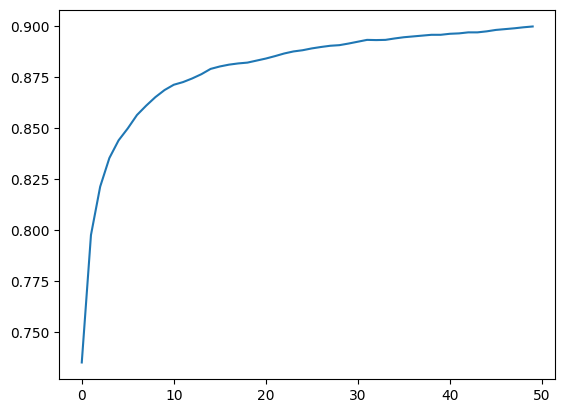

In [ ]:
plt.plot(range(len(test_accuracies)), test_accuracies)

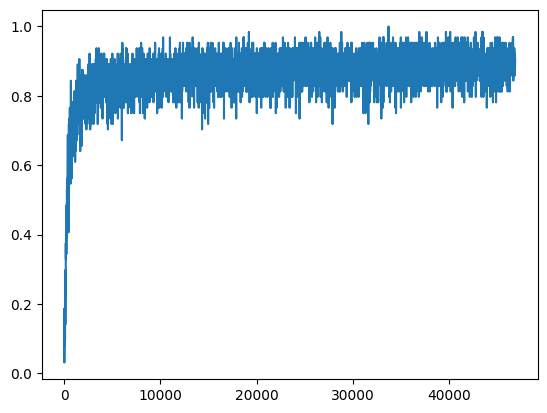

In [ ]:
plt.plot(range(len(train_accuracies))[::10], train_accuracies[::10])

### Exercise 2. Multilayer convolutional neural network
CNN using PyTorch with SGD and cross-entropy loss. Reach 98% accuracy.

1. How many learnable weights does the network contain? Compare with previous exercise.
2. Learning curve plot.

**Base class CNN**

In [12]:
# Creating new datasets with dimensions tailored for CNN networks
train_dataset_cnn = data.TensorDataset(X_train_tensor.view(60000, 1, 28, 28), Y_train_tensor)
test_dataset_cnn = data.TensorDataset(X_test_tensor.view(10000, 1, 28, 28), Y_test_tensor)

In [13]:
class ConvNetwork(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(2, stride=2)
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.relu = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(2, stride=2)
        self.conv3 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()
        self.fullyconnected = torch.nn.Linear(32*7*7, 10)
        self.softm = torch.nn.Softmax(dim=1)

        self.components = torch.nn.ModuleList([self.conv1,
                                               self.pool,
                                               self.conv2,
                                               self.relu,
                                               self.pool2,
                                               self.conv3,
                                               self.relu2,
                                               self.flatten,
                                               self.fullyconnected,
                                               self.softm])
    
    def forward(self, x):

        for l in self.components:
            x = l(x)

        return x

**Optimizing and training**

In [ ]:
model = ConvNetwork()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)

num_epochs = 50
batch_size = 100 # size used in lab1

def train(model, traindata, testdata, num_epochs=40, batch_size=100, optmzr="sgd"):

    # Optimizer
    if optmzr == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0)
    
    if optmzr == "adam":
        pass # kommer senare

    # Load data
    train_loader = data.DataLoader(traindata, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(testdata, batch_size=batch_size)
    


    # Lists for later plotting
    train_costs = []
    train_accuracies = []
    test_costs = []
    test_accuracies = []

    # For time tracking
    starttime = time.time()

    # Same training structure as from lab 2
    for epoch in range(1, num_epochs):
        model.train()
        print(f"Entering epoch {epoch} out of {num_epochs}.")

        for b in train_loader:
            # b[0][0][0] är en bild. Ser bra ut: kan plottas

            # print(b[0].size())
            # plt.imshow(b[0][4][0])

            # Training
            optimizer.zero_grad()
            loss, train_acc = compute_loss(model, b)
            loss.backward()
            optimizer.step()

            # Appending training metrics
            train_costs.append(loss.item())
            train_accuracies.append(train_acc)
            
        # Appending test metrics
        temp_costs = []
        temp_acc = []
        
        for b in test_loader:
            loss, acc = compute_loss(model, b)
            temp_costs.append(loss.item())
            temp_acc.append(acc)
        
        test_costs.append(np.mean(temp_costs))
        test_accuracies.append(np.mean(temp_acc))

        t0 = time.time()
        t_tot = t0-starttime
        avgspeed = t_tot / epoch
        est_time_remaining = (avgspeed) * (num_epochs - epoch)

        print(f"Current testing loss:      {test_costs[-1]:>10.4f}")
        print(f"Current test accuracy:     {test_accuracies[-1]:>10.2f}")
        print(f"Ellapsed time:             {round(t0 - starttime, 2):>10.2f} seconds.")
        print(f"Estimated time remaining:  {round(est_time_remaining, 2):>10.2f} seconds.")
        print()
    
    return train_costs, train_accuracies, test_costs, test_accuracies

trc, tra, tec, tac = train(model, train_dataset_cnn, test_dataset_cnn)

# TODO
# Antagligen något fel med inläsningen av datasetet. Dvs reshape (60000, 784) -> (60000, 1, 28, 28) antagligen fel.
# Unsqueeze och transpose?


Entering epoch 1 out of 40.
Current testing loss:          2.3020
Current test accuracy:           0.13
Ellapsed time:                   9.51 seconds.
Estimated time remaining:      371.08 seconds.

Entering epoch 2 out of 40.
Current testing loss:          2.3013
Current test accuracy:           0.29
Ellapsed time:                  18.58 seconds.
Estimated time remaining:      353.00 seconds.

Entering epoch 3 out of 40.
Current testing loss:          2.3003
Current test accuracy:           0.34
Ellapsed time:                  27.83 seconds.
Estimated time remaining:      343.21 seconds.

Entering epoch 4 out of 40.
Current testing loss:          2.2991
Current test accuracy:           0.33
Ellapsed time:                  36.97 seconds.
Estimated time remaining:      332.71 seconds.

Entering epoch 5 out of 40.
Current testing loss:          2.2972
Current test accuracy:           0.31
Ellapsed time:                  47.93 seconds.
Estimated time remaining:      335.49 seconds.

Enter

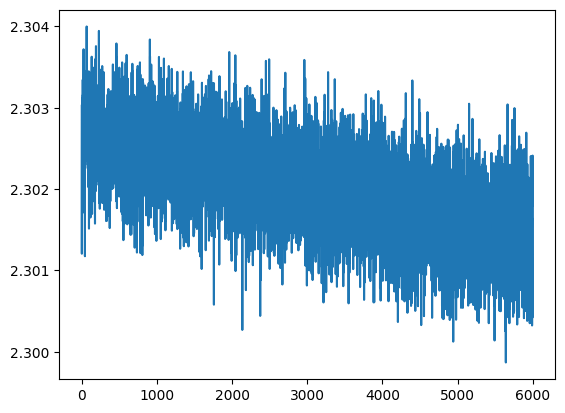

In [ ]:
plt.plot(range(len(trc)), trc)